# Tutorial for eMut

## Introduction
The eMut, an integrated pipeline for detecting, imputing, and characterizing non-coding mutations in cis-regulatory elements(CREs) with functional consequences at the single-cell level.


## workflow
Briefly, eMut consists of two main modules: mutation detection and functional interpretation. <br />
Step1. Mutation detection: eMut detects mutations in each cell by implementing methods such as Monopogen or GATK by single-cell chromatin accessibility data. <br />
Step2. Mutation imputation (optional): Given the sparse of scATAC-seq data, we further imputed candidate mutated cells by network propagation using mutated cells (seed cells) in cell-cell similarity graph. <br />
Step3. Functional interpretation: <br />
1) recognize cell type-specific or lineage-specific mutations; 
2) identify hypermutated CREs with significant excess of mutations to characterize potentially important enhancers; 
3) predict the effects of mutations on transcription factor motifs (loss or gain);
4) compare target gene expression changes between mutated cells (or samples) and wild-type.

### Step1. Mutation detection
Input: <br>
Bam-format files of scATAC-seq data<br>
As an example, the [Monopogen](https://github.com/KChen-lab/Monopogen) implementation of somatic mutation prediction for a single sample (without matched normal samples), as well as the simultaneous detection of somatic and germline mutations based on [GATK Mutect2](https://github.com/broadinstitute/gatk), are shown here.

####  GATK 
example data and script in /eMut/MutationDetection/test_run/

In [ ]:
/MutationDetection/run_GATK.py -b demo.bam -p peaks.bed -o GATK \
    --reference ./ReferenceGenome/GATK_GRCh38/Homo_sapiens_assembly38.fasta \
    --vepcache ./reference/VEP_hg38 

####  Monopogen
example data and script in /eMut/MutationDetection/test_run/

In [ ]:
/MutationDetection/run_monopogen.py -b demo.bam -o Monopogen \
    --variant ./app/Monopogen/1KG3 \
    --reference ./ReferenceGenome/GATK_GRCh38/Homo_sapiens_assembly38.fasta \
    --monopogen ./eMut/Monopogen \
    --cells demo_cells.csv \
    --region region.lst

#### SNV extraction for Monopogen

In [ ]:
library(graphics)
library(ggforce)
library(scales)
library(ggpubr)
library(ggplot2)
library(pbapply)
library(SCAVENGE)
library(Seurat)
library(Signac)
library(ArchR)
library(eMut)

In [ ]:
### SNV data.frame
samples<-c("ALL",paste0("AML",1:10))
inputDirs<-paste0("./2-AML/Monopogen/",samples,"/somatic")
names(inputDirs)<-samples
SNV.df<-SNVExtract(inputDirs)

In [10]:
head(SNV.df)

CHROM,POS,REF,ALT,ID,Depth_total,Depth_ref,Depth_alt,SVM_pos_score,LDrefine_twoLoci_score,LDrefine_trioLoci_score,LDrefine_merged_score,BAF_alt,sample
<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<chr>
chr1,1780416,G,A,chr1;1780416;G;A,16,8,7,0.9927329,NA,NA,NA,0.4666667,ALL
chr1,3900826,C,G,chr1;3900826;C;G,35,5,27,0.9941635,0.0,NA,NA,0.8437500,ALL
chr1,16889487,C,A,chr1;16889487;C;A,9,5,4,0.9881099,0.0,NA,NA,0.4444444,ALL
chr1,16896253,G,C,chr1;16896253;G;C,28,18,10,0.3393693,0.3,NA,NA,0.3571429,ALL
chr1,28247308,G,T,chr1;28247308;G;T,39,19,18,0.9943517,NA,NA,NA,0.4864865,ALL
chr1,58784151,G,T,chr1;58784151;G;T,48,24,21,0.9924848,NA,NA,NA,0.4666667,ALL


Loading required package: ComplexHeatmap

Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.2.1”
ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘ComplexHeatmap’


The following object is masked from ‘package:plotly’:

    add_heatmap


'magick' package is suggested to install to give better rasterization.



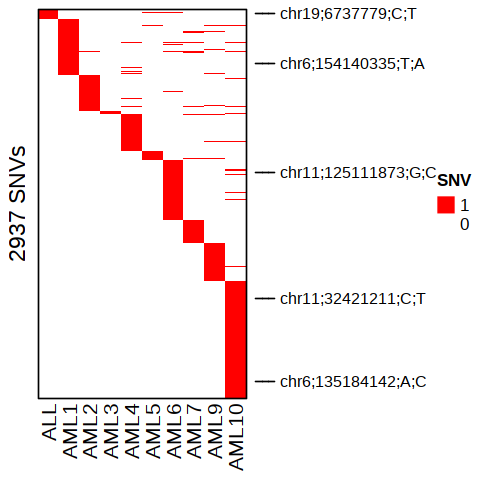

In [9]:
options(repr.plot.width = 4, repr.plot.height = 4)
plotSNVSamples(SNV.df,mut.show=c(33,414,1234,2184,2809))

In [13]:
### SNV matrix
mat<-SNVMatrixExtract(inputDirs)
str(mat)

 chr [1:2937, 1:70068] "0/0" "0/0" "0/0" "0/0" "0/0" "0/0" "0/0" "0/0" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:2937] "chr1:1780416:G:A" "chr1:3900826:C:G" "chr1:16889487:C:A" "chr1:16896253:G:C" ...
  ..$ : chr [1:70068] "ALL#ACCACTGTACTATGCACAACCACA" "ALL#ATCCTGTAAGATGTACGAGTTAGC" "ALL#CAGCGTTACCGTGAGAAGATGTAC" "ALL#CCTCCTGAAGAGTCAAGCGAGTAA" ...


### Step2. Mutation imputation (optional)
Considering dropout events due to sparsity of single-cell technical, we refer to [SCAVENGE](https://github.com/sankaranlab/SCAVENGE) with its default parameters to infer potential mutated cells. Briefly, a M-kNN graph was constructed based on scATAC-seq data to represent cell-cell similarity. For a given mutation, the mutated cells (as seed cells) were projected onto the M-kNN graph. Through network propagation of these seed nodes, relevant cells were identified as potential mutated cells.<br>
Input: <br>
(1) mutation profile: mutation-by-cell matrix (The matrix can be organized from Monopogen results introduced as step1); <br> 
(2) scATAC-seq data: peak-by-cell matrix or knnGraph (obatined from ArchR or signac object); <br>

In [15]:
load("./eMut/data/mutualknn30.Rdata")  # m-knn graph   (see detials in SCAVENGE)
TRS.list<-SNVImputation(countMatrix=NULL,            # peak-by-cell matrix(obatined from ArchR or signac object)
                        knnGraph=mutualknn30,        # knnGraph 
                        SNVMatrix=mat,               # mutation-by-cell matrix
                        mutations=row.names(mat),    # mutations
                        numk=30,                     # Number of nearest neighbors 
                        queryCell_cutoff=5,          # Minimum number of mutant cells, greater than this threshold for subsequent analysis
                        ncors=5)       

[1] "KNN Neighborhood Graphs:"
[1] "Imputation for 2937 mutations"


Stationary step: 106

Stationary Delta: 9.63674486179174e-06

Get started!



In [21]:
str(TRS.list[[1]])   

'data.frame':	77838 obs. of  5 variables:
 $ np_score         : num  6.07e-06 1.85e-06 3.43e-07 2.37e-06 1.24e-06 ...
 $ TRS_score        : num  0.08456 0.02584 0.00478 0.03306 0.01726 ...
 $ seed             : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ seed_idx         : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ true_cell_top_idx: logi  TRUE FALSE FALSE FALSE FALSE FALSE ...


Successfully loaded ArchRProject!

Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 60 rows containing missing values (`geom_point()`).”


NULL

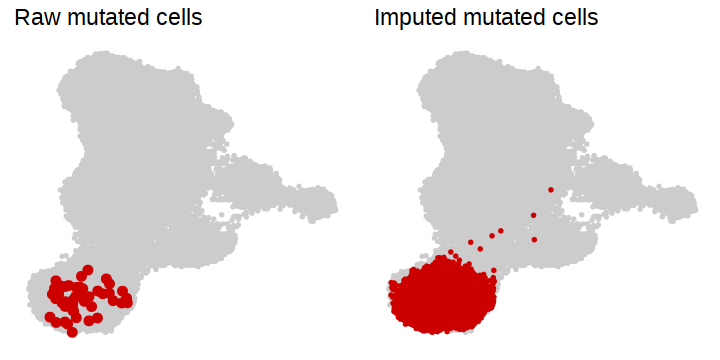

In [23]:
options(repr.plot.width = 6, repr.plot.height =3)
proj<- loadArchRProject(path = "./summary/ArchR", force = FALSE, showLogo = FALSE)
UMAP.loc<-proj@embeddings@listData$UMAP@listData$df
row.names(UMAP.loc)<-proj@embeddings@listData$UMAP@listData$params$projectID@rownames
colnames(UMAP.loc)<-c("UMAP1","UMAP2")
plotUMAP(UMAP.loc,TRS.list[["chr11:32421211:C:T"]])

### Step3. functional interpertaion
#### (1) cell type enrichment
Input: <br>
(1) mutation profile: mutation-by-cell matrix (raw or imputed); <br>
(2) scATAC-seq data: ArchR or signac object; <br>
Here is an example demonstration with an ArchR object .

In [24]:
cells<-row.names(getCellColData(proj))
cellTypes<-proj$NamedClust

##### cell type enrichment for mutation profile (raw)

In [26]:
mut.type<-pblapply(row.names(mat),function(x){
    mutCells<-colnames(mat)[which(mat[x,]=="0/1" | mat[x,]=="1/1")]  # mutated cells
    result<-cellTypeEnrich(cells,                  # The names of all cells
                         cellTypes,                # The cell type
                         mutCells,                 # Mutated cells
                         mutCells_cutoff=50,       # Muttaion with a number of mutated cells greater than this threshold were subsequently analyzed
                         cellType_cutoff=50)       # Cell type with a number of mutated cells greater than this threshold were subsequently analyzed
    if(!is.null(result)){
      result$mut<-rep(x,nrow(result))
      result  
    }
}) %>% rbindlist()
mut.type$p<-p.adjust(mut.type$p)

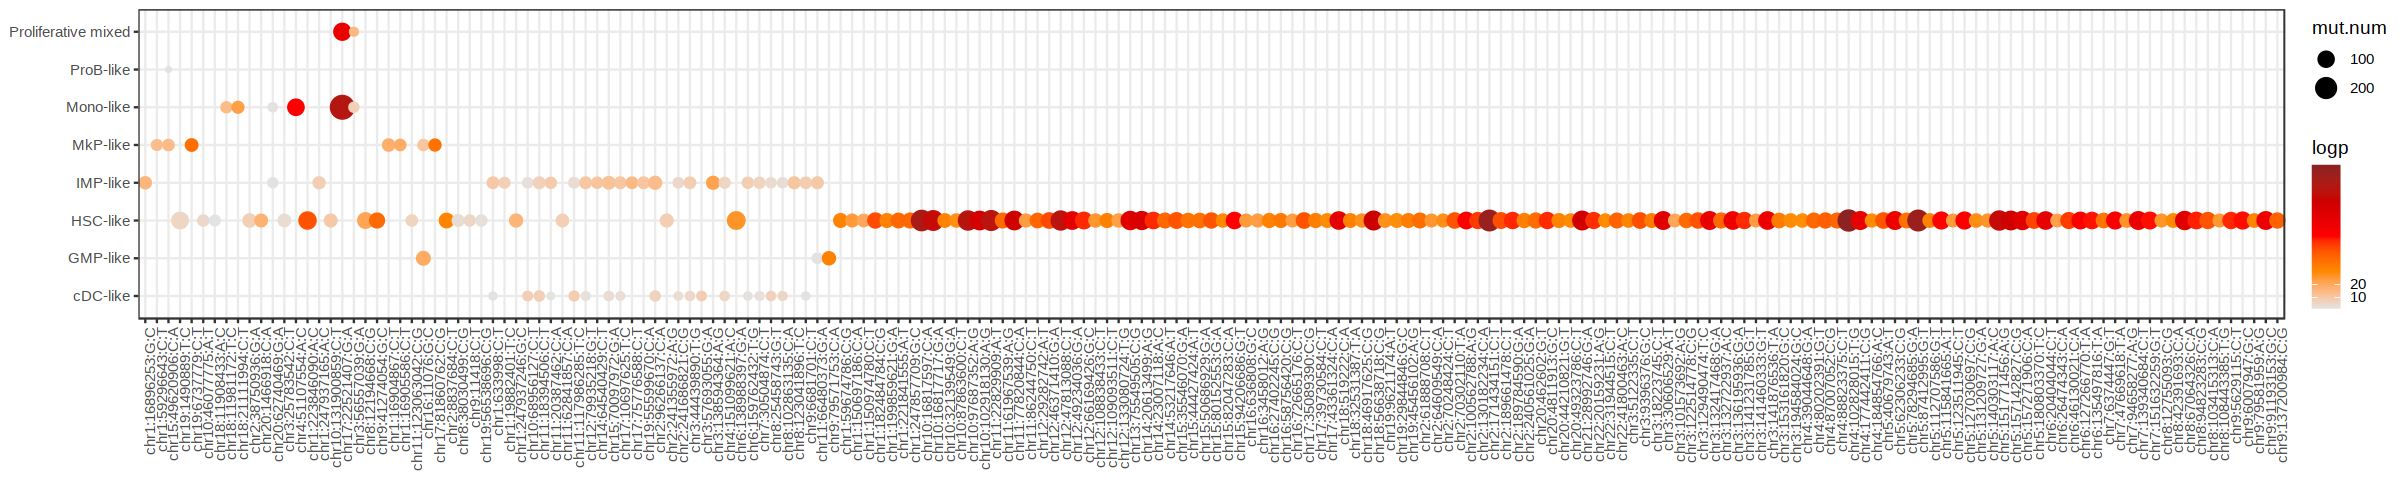

In [27]:
options(repr.plot.width = 20, repr.plot.height = 4)
mut.type$logp<-log10(1/(mut.type$p))
mut.type$logp[is.infinite(mut.type$logp)]<-max(mut.type$logp[!is.infinite(mut.type$logp)])
mut.type<-mut.type[mut.type$p<0.05,]
union.mut<-mut.type$mut[mut.type$p<0.05] %>% unique()
mut.type<-mut.type[mut.type$p<0.05,]

p<-ggplot(mut.type,aes(x=factor(mut,union.mut),y=types))+
  geom_point(aes(size=mut.num,color=logp))+
  labs(x=NULL,y=NULL)+
  theme_bw()+
  theme(axis.text.x=element_text(angle=90,hjust=1))+
  scale_color_gradientn(colors = c("gray89","darkorange","red","red3","brown4"),
                        breaks = c(0,1.3,10,20,300))
p

##### cell type enrichment for mutation profile (imputed)

In [28]:
mut.type<-pblapply(names(TRS.list),function(x){
    mutCells<-row.names(TRS.list[[x]])[TRS.list[[x]]$true_cell_top_idx==TRUE] #imputed mutated cells
    result<-cellTypeEnrich(cells,
                         cellTypes,
                         mutCells,
                         mutCells_cutoff=50,
                         cellType_cutoff=50)
    if(!is.null(result)){
      result$mut<-rep(x,nrow(result))
      result  
    }
}) %>% rbindlist()
mut.type$p<-p.adjust(mut.type$p)

####  (2) hyperMutated CREs
Among all accessible regions, we adapted the [ActiveDriverWGS](https://github.com/reimandlab/ActiveDriverWGSR) method with modification to identify hypermuated CREs based on scATAC-seq data. Specifically, we changed adjacent flanking genomic regions to flanking accessible regions (±500 kbps) for training the model of expected mutations, we identified hypermuated CREs (observed excess expected mutations) in each sample. 
Input: <br>
(1) mutation profile: annotated mutation file(VCf/maf format); <br>
(2) peak file: The genomic location of chromatin accessible region; <br>

In [ ]:
library(ActiveDriverWGS)
library(tidyr)
library(BSgenome.Hsapiens.UCSC.hg38)
library(eMut)

In [35]:
##  load  mutation profile
mut.df<-data.table::fread(
    file = "./2.GATK/all-scATAC/AML10.maf",
    sep = "\t",stringsAsFactors = FALSE,verbose = FALSE,data.table = TRUE,
    showProgress = TRUE,header = TRUE,fill = TRUE,
    skip =1,quote = "")
mut.df<-mut.df[mut.df$FILTER=="PASS",]
mut.df<-mut.df[,c("Chromosome","Start_Position","End_Position",
                             "Reference_Allele","Tumor_Seq_Allele2","Tumor_Sample_Barcode")]
colnames(mut.df)<-c("chr","pos1","pos2","ref","alt","patient")
mut.df<-mut.df[mut.df$chr!="chrM",]

##  load peak
peaks.df<-read.table("./eMut/data/peaks.bed",header=F,quote="",sep="\t")
colnames(peaks.df)<-c("chr","start","end","id")
openRegions<-GenomicRanges::GRanges(seqnames=peaks.df$chr, 
                                    IRanges::IRanges(peaks.df$start,peaks.df$end))
##  identify hypermutated CREs
hyperMut<-ActiveDriverCRE(mutations = mut.df,              # mutations
                         elements = peaks.df,              # Open region as elements 
                         ref_genome = "hg38",              # Reference genome
                         mc.cores=4,                       # Number of threads
                         window_size=1000000,              # The window size of flanking region as background 
                         detect_depleted_mutations=FALSE,  # The detection of hypomutated region
                         openRegions = openRegions,        # all open regions (union of all peaks)
                         recovery.dir="./tmp/")  # Temporary file paths to quickly recover results


Creating ./tmp/



0 remove hypermut, n= 0 ,  0 %
hypermuted samples:   

reversing 0 positions
Removing  0  invalid SNVs & indels

Number of Elements with 0 Mutations:  145218 
Tests to do:  43389 


In [36]:
str(hyperMut) 

'data.frame':	188607 obs. of  12 variables:
 $ id                : chr  "chr17-22521269-22521540" "chr3-93470276-93470822" "chr16-46389694-46390830" "chr17-26885578-26885849" ...
 $ pp_element        : num  1.00e-300 1.00e-300 7.09e-190 3.55e-150 1.15e-130 ...
 $ element_muts_obs  : num  265 1209 246 111 115 ...
 $ element_muts_exp  : num  11.24 65.91 27.98 2.33 4.82 ...
 $ element_enriched  : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ pp_site           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ site_muts_obs     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ site_muts_exp     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ site_enriched     : logi  NA NA NA NA NA NA ...
 $ fdr_element       : num  9.43e-296 9.43e-296 4.46e-185 1.67e-145 4.32e-126 ...
 $ fdr_site          : num  1 1 1 1 1 1 1 1 1 1 ...
 $ has_site_mutations: chr  "" "" "" "" ...


####  (3) prediction of TF binding motif change
To explore the impact of mutations in their located enhancer, [motifbreakR](https://github.com/Simon-Coetzee/motifBreakR) was applied to predict TF motif disruptions (loss or gain) for a large number of single-nucleotide variants using several different sources of TF motifs (e.g. JASPAR and ENCODE). In the predicted results, "strong" effect motif change will be considered as the potential impact of mutations.
Input: <br>
(1) mutation profile: mutation file(VCf/maf format); <br>
Function parameters are consistent with motifbreakR

In [ ]:
library(motifbreakR)
library(MotifDb)
library(BSgenome.Hsapiens.UCSC.hg38)
library(eMut)
library(dplyr)

In [48]:
##   change mutation format
mut<-data.frame(Chromosome=SNV.df$CHROM,Start_Position=SNV.df$POS-1,End_Position=SNV.df$POS,
                names=gsub(";",":",SNV.df$ID),score=rep(0,nrow(SNV.df)),strand=rep("+",nrow(SNV.df)))
mut<-mut %>% distinct(names,.keep_all = TRUE)
write.table(mut,file="./eMut/data/SNVsForMotifBreakR.bed",sep="\t",
            col.names = F,row.names = F,quote=F)

##   motif change prediction 
data(motifbreakR_motif)
ENCODE<-subset (motifbreakR_motif, dataSource=="ENCODE-motif" & organism=="Hsapiens")
snps.mb.frombed <- snps.from.file(file = "./eMut/data/SNVsForMotifBreakR.bed", 
                                  search.genome = BSgenome.Hsapiens.UCSC.hg38,
                                  format = "bed")

SNV.motifs <- motifbreakR(snpList = snps.mb.frombed, filterp = TRUE,
                       pwmList = ENCODE,
                       threshold = 1e-4,
                       method = "ic",
                       bkg = c(A=0.25, C=0.25, G=0.25, T=0.25),
                       BPPARAM = BiocParallel::MulticoreParam(5))

In [49]:
head(SNV.motifs)

GRanges object with 6 ranges and 23 metadata columns:
                  seqnames    ranges strand |          SNP_id            REF
                     <Rle> <IRanges>  <Rle> |     <character> <DNAStringSet>
  chr1:633998:C:T     chr1    633998      - | chr1:633998:C:T              C
  chr1:633998:C:T     chr1    633998      + | chr1:633998:C:T              C
  chr1:778706:A:T     chr1    778706      - | chr1:778706:A:T              A
  chr1:778706:A:T     chr1    778706      + | chr1:778706:A:T              A
  chr1:778706:A:T     chr1    778706      - | chr1:778706:A:T              A
  chr1:778706:A:T     chr1    778706      - | chr1:778706:A:T              A
                             ALT     varType motifPos  geneSymbol   dataSource
                  <DNAStringSet> <character>   <list> <character>  <character>
  chr1:633998:C:T              T         SNV    -5, 8      POU3F2 ENCODE-motif
  chr1:633998:C:T              T         SNV    -6, 1         TBP ENCODE-motif
  chr1:778706:

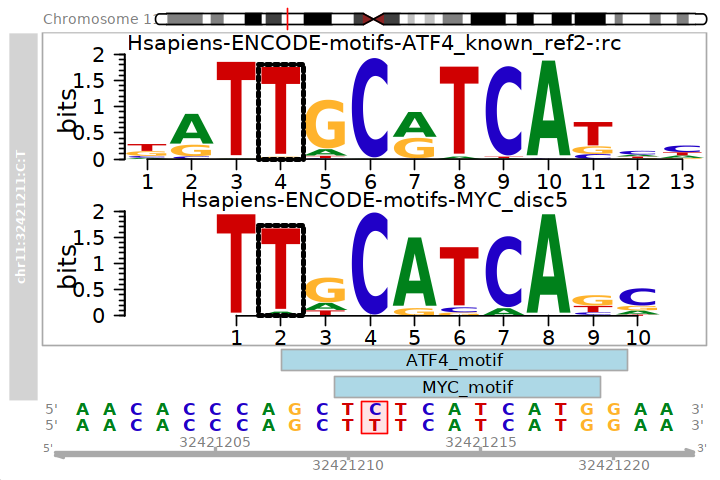

In [38]:
options(repr.plot.width =6, repr.plot.height = 4)
plotMB(SNV.motifs,rsid="chr11:32421211:C:T",effect="strong")

####  (4) Comparsion of target gene expression between mutated samples(cells) and wild-type
Input: <br>
(1) mutation profile: Combined mutations for samples (or cells) <br>
(2) mutation annotated file: The data needs to contain information about the mutation and its corresponding target gene (nearest neighbor gene or mutation located enhancer linked gene); <br>
(3) gene expression matrix : gene-by-sample matrix or gene-by cell matrix; <br>
Since we don't have matching single-cell data for mutated cells, here is an example of transcriptome data for the mutated samples.

In [ ]:
load("./eMut/data/SNV_anno.Rdata")   
load("./eMut/data/tpm.Rdata")  
result<-mutTargetExp(SNV.df,SNV.anno,tpm)

In [48]:
head(result)

gene,mutation,mutSamples,pValue,foldchange,adjsP
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
RNASEH1,chr2;3558073;C;A,AML9,4.420168e-01,1.1540143,0.6313629990
ZNF25,chr10;37976898;T;C,AML3,2.422969e-01,1.0293263,0.4352671717
REST,chr4;56907875;T;C,AML10,5.714286e-02,0.6500489,0.1870341615
PTGER4,chr5;40386541;C;T,AML6,1.484594e-02,3.3268807,0.0841502719
LARP4B,chr10;931986;C;T,AML10,5.487395e-01,0.8999290,0.7118543055
PPP3R1,chr2;68252591;G;A,AML1;AML2;AML4;AML6;AML7;AML9,5.994401e-08,1.6598736,0.0001444051


[1] "select mutations:"
[1] "plot mutation profile:"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



[1] "plot gene expression profile:"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



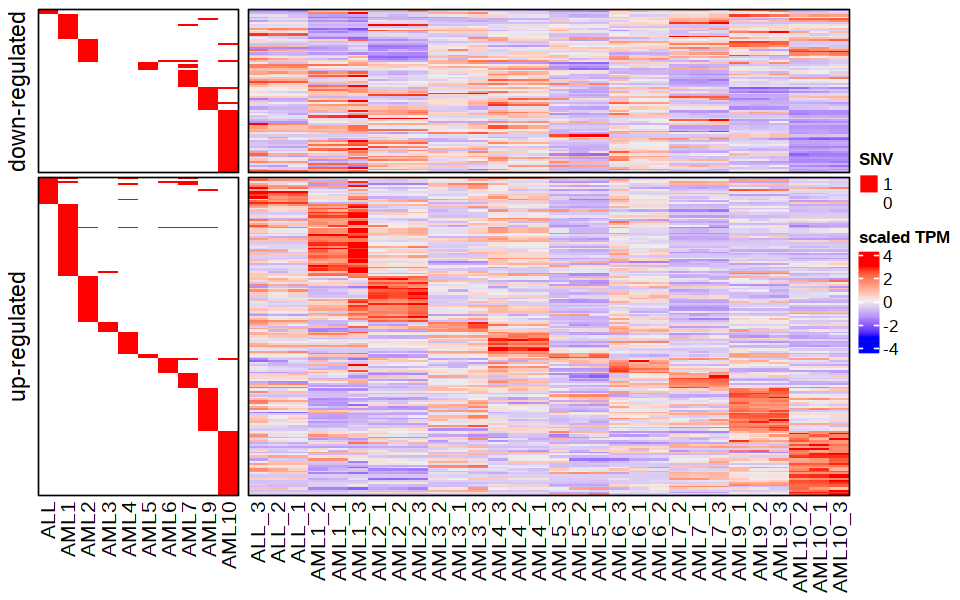

In [46]:
options(repr.plot.width =8, repr.plot.height = 5)
plotImpact(SNV.df,tpm,result,0.05)